<a href="https://colab.research.google.com/github/AEW2015/fpga-colab/blob/main/xqrku060_FMECA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

AMD-Xilinx offers a Radiaton Tolerant KU060 FPGA, but how often do these devices fail and what is the effect of mitigation?


<figure>
    <img src="https://cf-images.us-east-1.prod.boltdns.net/v1/static/17209957001/321ccd1b-67b4-452a-a0a9-fc5586fdb87c/a3403ace-0540-42cc-a7e6-e042e5a7beb1/1280x720/match/image.jpg"
    width="450"
    alt="FT KU060">
    <figcaption>AMD-Xilin Space Resilient SRAM FPGA</figcaption>
</figure>

Failure mode effects and criticality analysis (FMECA)

<figure>
    <img src="https://i0.wp.com/www.apifirst.in/wp-content/uploads/2020/05/Fig-1-1.png"
    width="450"
    alt="Risk Matrix">
    <figcaption>FMECA Risk Matrix</figcaption>
</figure>



Quick points:
*   Using Public Vendor Heavy Ion Data
*   Vendor, Public, and Opensource Tools and designs
*   Map data to an orbit for failures for a specific designs



Assumptions will be listed, but can be changed to match your situation:
*   [DS882](https://docs.xilinx.com/v/u/en-US/ds882-xqr-kintex-ultrascale) Weibull Fit Curves, and SEFI rates
*   [Spenvis](https://www.spenvis.oma.be/) with listed configs
*   GEO orbit
*   100 mils of aluminum shiledling
*   Simple CRAM Scrubbing (only look at Single CRAM events)
*   No data for freqnecy-based SETI upsets
*   [BYU SpyDrNet TMR Tools](https://github.com/byuccl/spydrnet-tmr/tree/main)
*   Other assumptions listed below



# Orbit Upset Rates

![Spenvis logo](https://www.spenvis.oma.be/images/spenvislogo.gif)

Spenvis Config:
1.  Orbit is geostionary, 1 day orbit, longitude 0, Jan 2020 Launch
2.  Solar Partical Flux CREMA-96, H to U, Worst Week, Mag Shield (quiet)
3. Short-Term SEU rate, 0.254 cm Shield, Si (CREME-86), x*y = 0.0004 um, z = 2 um
4. Heavy Ion Weibull Function



In [3]:
CRAM_bit_day    = 5.5132E-09
BRAM_bit_day    = 7.8714E-09
SLR_device_day  = 1.1775E-03
CNT_device_day  = 7.6083E-04
DSP_device_day  = 1.3997E-03
GTH_device_day  = 9.0687E-05
IOB_device_day  = 1.9342E-03
PLL_device_day  = 4.9828E-05
MMCM_device_day = 4.9828E-05
SEFI_device_day = 4.5e-4

# Device Failures

<figure>
    <img src="https://www.xilinx.com/content/xilinx/en/products/silicon-devices/fpga/rt-kintex-ultrascale/_jcr_content/root/imageTabParsys/childParsys-productAdvantages/xilinxcolumns/childParsys-1/xilinximage.img.png/1684954227147.png"
    width="350"
    alt="FPGA Layout">
    <figcaption>KU060 FPGA Layout</figcaption>
</figure>

Apply this to the Whole device:

*   Full Bitstream is 192,999,264 bits:
  * CRAM is 153186144 bits (type 0 frames)
  * BRAM is 39813120 bits (type 1 frames)



In [4]:
CRAM_device_day = CRAM_bit_day * 153186144
BRAM_device_day = BRAM_bit_day * 39813120

In [5]:
Full_device_day = CRAM_device_day + BRAM_device_day + SLR_device_day + CNT_device_day + DSP_device_day \
                + GTH_device_day + IOB_device_day + PLL_device_day + MMCM_device_day + SEFI_device_day
print("FPGA will see a device failure every {0:0.4} hours".format(24/Full_device_day))

FPGA will see a device failure every 20.62 hours


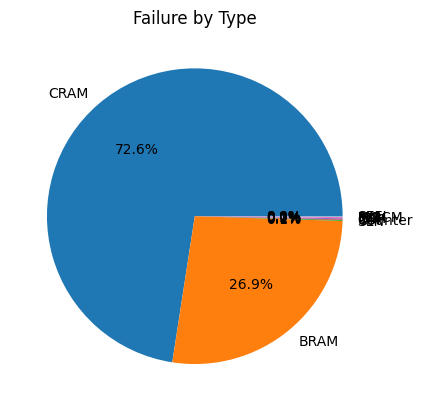

In [6]:
import matplotlib.pyplot as plt

labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_device_day, BRAM_device_day, SLR_device_day, CNT_device_day,DSP_device_day,\
         GTH_device_day,IOB_device_day,PLL_device_day,MMCM_device_day,SEFI_device_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

# Embedded Processors

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/devkit_2_procs.png?raw=true"
    width="350"
    alt="Proc Tiles">
    <figcaption>Embedded processor Tiles</figcaption>
</figure>

117 VexRiscv Processor were implmented to "fill" the KU060 FPGA with __96.38%__ LUT utilization.  

Each processor had a 4KB combined IMEM/DMEM where they performed a size optimized CoreMark Benchmark.

Example Design Build: [Source](https://github.com/AEW2015/fpga-colab/tree/main/FIG/digilent_arty/dut)

## Design Failures

Fault Injection Example:
[ipynb](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/fault_injection/arty_a7_fault_injection.ipynb)

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with features not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
      * difficult to simulate for more detailed analysis
* Everything else based on utilization


In [7]:
CRAM_sensitivity = .0551
nFIFO_BRAM = .702
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .117
GTH_util = 0 # Not used
IOB_util = 2 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [8]:
BRAM_sensitivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [9]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 6.362288481320409 days


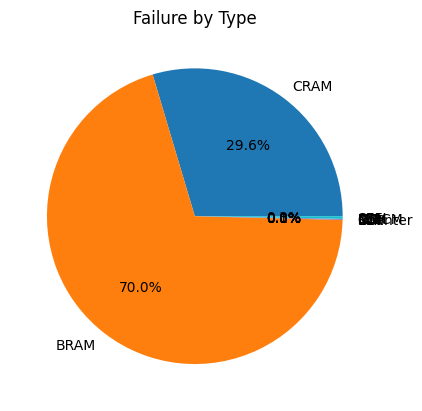

In [10]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Mitigated Design

Apply Fine-Grain/ Distrubuted TMR using BYU SpyDrNet TMR Python tools.

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/3-Figure2-1.png"
    width="350"
    alt="TMR Voters">
    <figcaption>TMR with Triplicated Voter</figcaption>
</figure>

This method takes a exported netlist from Vivado, modifies it, and then returns it to the Vivado PAR tools (or RapidWrite).

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/306e7102c922abd010baf5a1a957f9617bd647da/2-Figure1-1.png"
    width="350"
    alt="TMR Application">
    <figcaption>SpyDrNet TMR Flow</figcaption>
</figure>

28 TMR VexRiscv Processor were implmented in the KU060 at __93.51%__ LUT utilization.

Example Python TMR Flow: [ipynb](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/tmr/digilent_arty_SpyDrNet_TMR.ipynb)

Example Build TCL script: [TCL](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/tmr/build_tmr.tcl)

Another Python Example: [ipynb](https://github.com/AEW2015/fpga-colab/blob/main/SpyDrNet_TMR_examples.ipynb)

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 0.412% sensitivity for TMR BRAM (see Appendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [11]:
CRAM_sensitivity = .00079
nFIFO_BRAM = .476
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .117
GTH_util = 0 # Not used
IOB_util = 2 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [12]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [13]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 1.908091985845966 Year


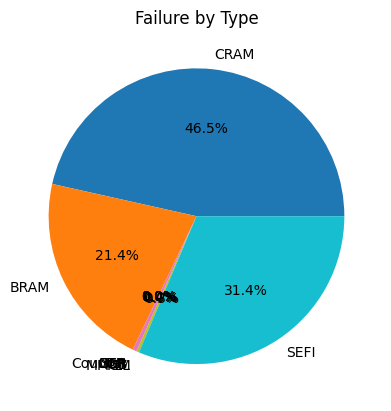

In [14]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Compare to Radiation Data

Radiation test with AlphaData KU060 Dev board

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/devkit2_cap.JPG?raw=true"
    width="350"
    alt="Rad Testing">
    <figcaption>LANSCE Neutron Radiation test</figcaption>
</figure>

In [15]:
nTMR_NEU_MFTF = 1/ 5.96E-08 # 1/ cross-section
TMR_NEU_MFTF = 1 / 5.58E-10 # 1/ cross-section

In [16]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

109.54086723298035 106.8100358422939


The GEO model based on Utilizaton, Analysis, and Fault injection closely matches the observed __TMR improvement__ during the Neutron Radiation test.

In [17]:
nTMR_processor_count = 117
TMR_processor_count = 28
nTMR_norm_perf = 1
TMR_norm_perf = 0.93

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

24.379864809801784 23.772079772079774


This applies the processor count and fMax to the improvement calculation.

### Publication for more info: [IEEE](https://ieeexplore.ieee.org/document/10012379)

# Soft Linux SoC Processor


This design looked at a more complex system, with a soft SoC generated with LiteX.  This SoC used the VexRiscv processor to run a BuildRoot Linux OS.

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/2-Figure1-1.png"
    width="650"
    alt="VexRiscv LiteX Config">
    <figcaption>Soft SoC generated by LiteX</figcaption>
</figure>

Example LiteX Gen:

F4PGA LiteX Arty [link](https://github.com/AEW2015/fpga-colab/blob/main/F4PGA_Litex_Arty.ipynb)

Linux on LiteX Repo: [link](https://github.com/litex-hub/linux-on-litex-vexriscv) (supports most dev boards)

## Design Failures

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [18]:
CRAM_sensitivity = .0057
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0054
GTH_util = 0 # Not used
IOB_util = 64 /620 # Various IO including DDR3
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [19]:
BRAM_sensitivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [20]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 61.2078058303423 days


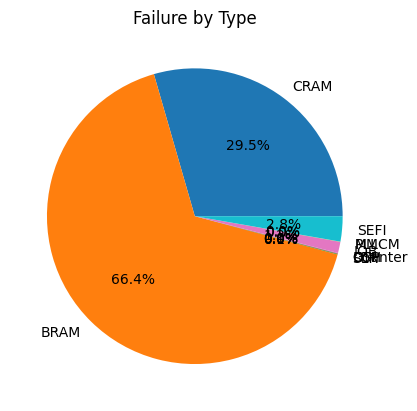

In [21]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Mitigated Design

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 0.412% sensitivity for BRAM (see Appendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [22]:
CRAM_sensitivity = .00039
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # Vaiours IO, same as above
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [23]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [24]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.450636114889419 Year


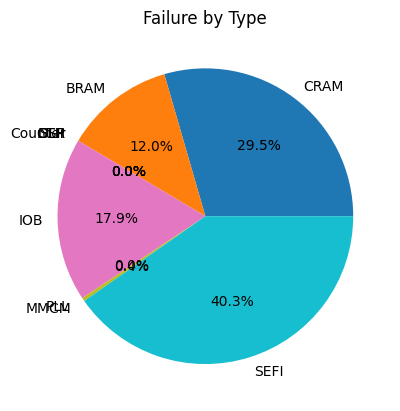

In [25]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Compare to Radiation Data

Radiation testing with Nexys7 (Series 7 FPGA) at LANSCE

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/4-Figure5-1.png"
    width="350"
    alt="VexRiscv LiteX Rad Test">
    <figcaption>LANSCE Radiation Test</figcaption>
</figure>

In [26]:
nTMR_NEU_MFTF = 1/ 2.09E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.42E-10 # 1/ cross-section

In [27]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

14.62386747606036 14.71830985915493


In [28]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

11.845332655608892 11.921830985915493


TMR improvement (efficacy) match between the GEO model and Radiation test, though radiation test was with a Artix 7.

### Publication for more info: [IEEE](https://ieeexplore.ieee.org/document/9386126)

# Bitstream Fault Analysis

BFAT is a tool used for analysis of a design's bitstream to evaluate and report any relevant information about given fault bits as well as any errors that they would cause in the design's implementation.

[BFAT github](https://github.com/byuccl/bfat)

BYU's Bistream Fault Analsysis tools uses the Senstive bits, the placed and routed design, and ProjectXRay Database to map failures. (Series 7 only at the moment)

<figure>
    <img src="https://github.com/byuccl/bfat/raw/main/bfat_flowchart.png"
    width="450"
    alt="BFAT Flow">
    <figcaption>BFAT Flow Graph</figcaption>
</figure>

BFAT Examples:

[Embedded Proccessor](https://github.com/AEW2015/fpga-colab/blob/main/FIG/digilent_arty/digilent_arty_BFAT.ipynb)

[Litex Example](https://github.com/AEW2015/fpga-colab/blob/main/BFAT_Litex_example.ipynb)

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/8-Table4-1.png"
    width="450"
    alt="BFAT Flow">
    <figcaption>Design Failures</figcaption>
</figure>

```======================================================================
                             Bit Group 28
======================================================================

Significant Bits:
------------------------------
bit_00402b84_87_1 (0->1)
	INT_R_X87Y143 - WW4BEG0 2-20 Routing Mux - Column Bit
	Resource Design Name: INT_R_X87Y143/WW4BEG0
	Shorts formed between net(s): ISERDESE2_13_n_8 (initially connected), Unconnected Wire(SW6END_N0_3)
	Affected PIPs:
		SW6END_N0_3->>WW4BEG0 (activated)
	Affected Resources:
		VexRiscvLitexSmpCluster_Cc1_Iw32Is4096Iy1_Dw32Ds4096Dy1_ITs4DTs4_Ldw128_Ood/dBridge_logic/io_output_rdata_fifo/storage_12_reg_6_i_10_TMR_2
		main_a7ddrphy_bitslip13_r1_reg_TMR_0[8]
		main_a7ddrphy_bitslip13_r1_reg_TMR_1[8]
		main_a7ddrphy_bitslip13_r1_reg_TMR_2[8]

	Vivado Tcl Commands:
		select_objects [get_pips {INT_R_X87Y143/INT_R.SW6END_N0_3->>WW4BEG0}]
		select_objects [get_nets {ISERDESE2_13_n_8}]
		select_objects [get_cells {VexRiscvLitexSmpCluster_Cc1_Iw32Is4096Iy1_Dw32Ds4096Dy1_ITs4DTs4_Ldw128_Ood/dBridge_logic/io_output_rdata_fifo/storage_12_reg_6_i_10_TMR_2 main_a7ddrphy_bitslip13_r1_reg_TMR_0[8] main_a7ddrphy_bitslip13_r1_reg_TMR_1[8] main_a7ddrphy_bitslip13_r1_reg_TMR_2[8]}]
```

<figure>
    <img src="https://d3i71xaburhd42.cloudfront.net/6f34b7eba74d2e2460e3af1f3edd310d8492b93f/9-Figure11-1.png"
    width="750"
    alt="BFAT Flow">
    <figcaption>Failure in Input Net before TMR</figcaption>
</figure>

### Publication for more info: [ACM](https://dl.acm.org/doi/10.1145/3543622.3573191)

# TMR with Placement guides


## Design Failures

Same as above, just run code to refresh numbers :)

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [29]:
CRAM_sensitivity = .0057
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0054
GTH_util = 0 # Not used
IOB_util = 64 /620 # Various IO
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [30]:
BRAM_sensitivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [31]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 61.2078058303423 days


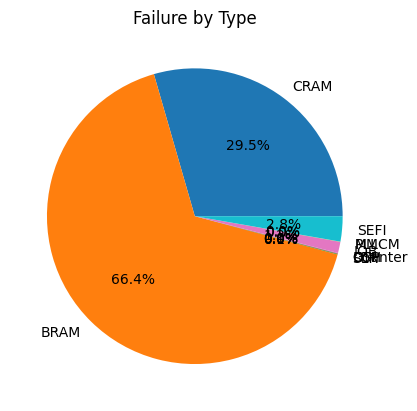

In [32]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Mitigated Design

Output Voters:

```
create_pblock poserd_0
add_cells_to_pblock [get_pblocks poserd_0] [get_cells -quiet [list \
    OSERDESE2_38_i_1_TMR_0_O_VOTER OSERDESE2_38_i_2_TMR_0_O_VOTER  \
    OSERDESE2_38_i_3_TMR_0_O_VOTER OSERDESE2_38_i_4_TMR_0_O_VOTER]]
resize_pblock [get_pblocks poserd_0] -add {SLICE_X162Y194:SLICE_X163Y199}
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/oserdes.png?raw=true"
    width="950"
    alt="BFAT Flow">
    <figcaption>OSERDES Placement Guide</figcaption>
</figure>

Input Flip-Flops
```
create_pblock piserd_0
add_cells_to_pblock [get_pblocks piserd_0] [get_cells -quiet [list \
    main_a7ddrphy_bitslip0_r3_reg_TMR_0[15] \
    main_a7ddrphy_bitslip0_r3_reg_TMR_2[15] \
    main_a7ddrphy_bitslip0_r3_reg_TMR_2[15]]]
resize_pblock [get_pblocks piserd_0] -add {SLICE_X162Y180:SLICE_X163Y185}
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/iserdes.png?raw=true"
    width="950"
    alt="BFAT Flow">
    <figcaption>ISERDES Placement Guide</figcaption>
</figure>

Stripping:
```
create_pblock pblock_dut_tmr_0
resize_pblock [get_pblocks pblock_dut_tmr_0] -add {
    SLICE_X0Y0:SLICE_X1Y249
    SLICE_X6Y0:SLICE_X7Y249
    ...
    SLICE_X96Y0:SLICE_X97Y249
    SLICE_X102Y0:SLICE_X103Y249
}
set_property IS_SOFT 0 [get_pblocks pblock_dut_tmr_0]
add_cells_to_pblock [get_pblocks pblock_dut_tmr_0] \
    [get_cells -hierarchical -regexp .*TMR(_VOTER)?_0.* -filter IS_PRIMITIVE==1]
```

<figure>
    <img src="https://github.com/AEW2015/fpga-colab/blob/main/images/pbtmr.png?raw=true"
    width="450"
    alt="BFAT Flow">
    <figcaption>Full Layout</figcaption>
</figure>

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 0.412% sensitivity for BRAM (see Appendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

__Point out CRAM sensitivity dropped by 3x from previous TMR!__

In [33]:
CRAM_sensitivity = .00013
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # Vaiours IO
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [34]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [35]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 3.0501286701350017 Year


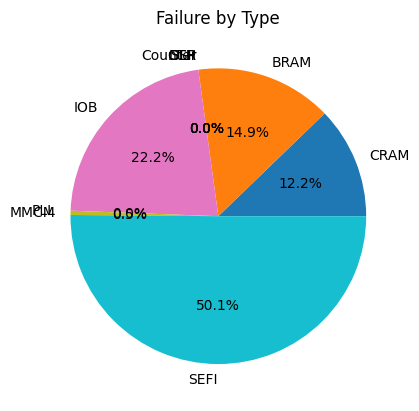

In [36]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Compare to Radiation Data

LANSCE Radiation Test with Nexys 7 dev board

<figure>
    <img src="https://ccl.byu.edu/images/news_2022/lansce_experiments.jpg"
    width="750"
    alt="VexRiscv LiteX Par Rad Test">
    <figcaption>LANSCE Radiation Test</figcaption>
</figure>

In [37]:
nTMR_NEU_MFTF = 1/ 2.59E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.14E-10 # 1/ cross-section

In [38]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

18.201265045422378 22.719298245614034


In [39]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

14.743024686792127 18.40263157894737


These results differ about 20%, but otherwise lineup well.  This could be due to the different failure modes from GEO to Neutron, BRAM sensitivity (still just a guess), or other unknowns.

# TMR with DDR EDAC


The Antmicro DDR4 tester to support the full 72-bit data bus for a simple radiation test with Series 7 FPGAs.

<figure>
    <img src="https://rowhammer-tester.readthedocs.io/en/latest/_images/ddr4_datacenter_dram_tester.jpg"
    width="750"
    alt="VexRiscv LiteX Par Rad Test">
    <figcaption>Antmicro DDR4 Tester</figcaption>
</figure>

## Design Failures

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
* Everything else based on utilization



In [40]:
CRAM_sensitivity = .01274
nFIFO_BRAM = .0692
SLR_util = .01 #Assume non-zero
CNT_util = .01 #Assume non-zero
DSP_util = .0067
GTH_util = 0 # Not used
IOB_util = 138 /620 # Lots of IO for DDR4 72-bit bus and address
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [41]:
BRAM_sensitivity_estimate = 0.5
CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate
SLR_design_day  = SLR_device_day * SLR_util
CNT_design_day  = CNT_device_day * CNT_util
DSP_design_day  = DSP_device_day * DSP_util
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [42]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
nTMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 44.416831373210684 days


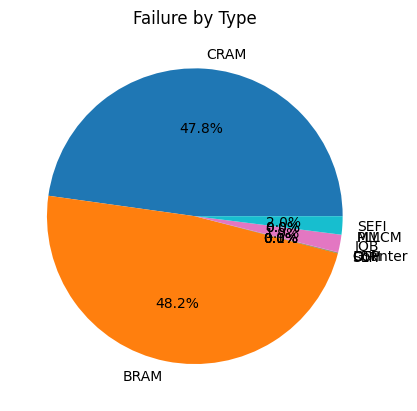

In [43]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Mitigated Design

Assumptions:
*   CRAM Sensitivity reported with random fault injeciton
*   BRAM:
  * Ignore unused BRAMs with feauters not tested
  * Ignore FIFO BRAMs with data in flight
  * Estimated a 50% "sensitivity" for operation BRAMs, but could be different
    * difficult to simulate for more detailed analysis
  * add an additional 0.412% sensitivity for BRAM (see Appendix)
* Everything else based on utilization
  * assume TMR protects SLR, CNT, & DSPs

In [44]:
CRAM_sensitivity = .00035
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0301
GTH_util = 0 # Not used
IOB_util = 75 /620 # Reduce IO since Data pins are protected
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [45]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [46]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day
print("FPGA will see a design failure every {0} Year".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.45402225473117 Year


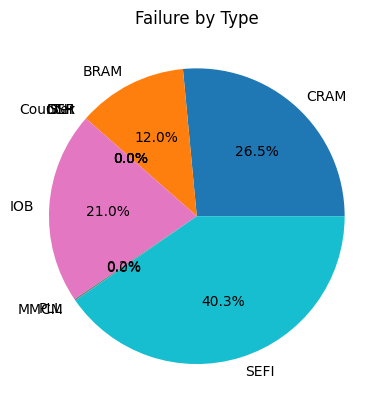

In [47]:
labels = 'CRAM', 'BRAM', 'SLR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI'
sizes = [CRAM_design_day, BRAM_design_day, SLR_design_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## Compare to Radiation Data

In [48]:
nTMR_NEU_MFTF = 1/ 3.82E-09 # 1/ cross-section
TMR_NEU_MFTF = 1 / 1.93E-10 # 1/ cross-section

In [49]:
GEO_improvement = TMR_GEO_MTTF/nTMR_GEO_MTTF
NEU_improvement = TMR_NEU_MFTF/nTMR_NEU_MFTF
print(GEO_improvement,NEU_improvement)

20.179999356756642 19.792746113989637


In [50]:
nTMR_processor_count = 1
TMR_processor_count = 1
nTMR_norm_perf = 1
TMR_norm_perf = 0.81

nTMR_GEO_MWBF = nTMR_GEO_MTTF * nTMR_processor_count * nTMR_norm_perf
TMR_GEO_MWBF = TMR_GEO_MTTF * TMR_processor_count * TMR_norm_perf

nTMR_NEU_MWBF = nTMR_NEU_MFTF * nTMR_processor_count * nTMR_norm_perf
TMR_NEU_MWBF = TMR_NEU_MFTF * TMR_processor_count * TMR_norm_perf

GEO_improvement = TMR_GEO_MWBF/nTMR_GEO_MWBF
NEU_improvement = TMR_NEU_MWBF/nTMR_NEU_MWBF
print(GEO_improvement,NEU_improvement)

16.345799478972882 16.032124352331607


The GEO model and Neutron radiation test line up very for this example.

# Dont forget DDR Failure Rates

The FPGA is not the only thing that has failures that can affect the operation for our system.  The external DDR module was not included in fault injection or radiation test with the LiteX SoC.

<figure>
    <img src="https://www.3d-plus.com/app/uploads/2023/04/3D4D48G48LB2825.png.webp" width="250" alt="3Dplus Memory">
    <figcaption>3Dplus Radiation Tolerant DDR4</figcaption>
</figure>

## Placement with SDRAM DDR

In [51]:
CRAM_sensitivity = .00013
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0162
GTH_util = 0 # Not used
IOB_util = 64 /620 # UART only
PLL_util = 0 / 24 # Not used
MMCM_util = 1 / 12

In [52]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [53]:
# Example with critical charge
DDR_bit_day = 7.0531E-12
# Same as BRAM for quick estimate
DDR_sensitivity_estimate = 0.5
# go for 16Gb (2GB)
DDR_device_day = 1024 * 1024 * 1024 * 16 * DDR_bit_day * DDR_sensitivity_estimate

In [54]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day + DDR_device_day
print("FPGA will see a design failure every {0} days".format(1/Full_design_day))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 16.264582918866775 days


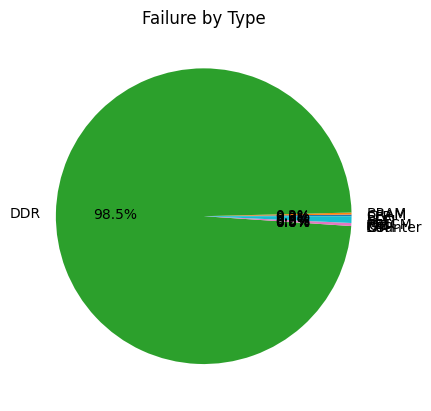

In [55]:
labels = 'CRAM', 'BRAM', 'DDR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI','SLR'
sizes = [CRAM_design_day, BRAM_design_day, DDR_device_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day,SLR_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## DDR ECC with SDRAM DDR

In [56]:
CRAM_sensitivity = .00035
nFIFO_BRAM = .2076
SLR_util = .03 #Assume non-zero
CNT_util = .03 #Assume non-zero
DSP_util = .0301
GTH_util = 0 # Not used
IOB_util = 75 /620 # Data lines protected by ECC
PLL_util = 1 / 24 # Not used
MMCM_util = 0 / 12

In [57]:
BRAM_sensitivity_estimate = 0.5
BRAM_TMR_sensitivity_estiamte = 0.00411983113735914
TMR_protected = 0

CRAM_design_day = CRAM_device_day * CRAM_sensitivity
BRAM_design_day = BRAM_device_day * nFIFO_BRAM * BRAM_sensitivity_estimate * BRAM_TMR_sensitivity_estiamte
SLR_design_day  = SLR_device_day * SLR_util * TMR_protected
CNT_design_day  = CNT_device_day * CNT_util * TMR_protected
DSP_design_day  = DSP_device_day * DSP_util * TMR_protected
GTH_design_day  = GTH_device_day * GTH_util
IOB_design_day  = IOB_device_day * IOB_util
PLL_design_day  = PLL_device_day * PLL_util
MMCM_design_day = MMCM_device_day * MMCM_util
SEFI_design_day = SEFI_device_day

In [58]:
# Example with critical charge
DDR_bit_day = 7.0531E-12
# Same as BRAM for quick estimate
DDR_sensitivity_estimate = 0.5
# Simple ECC estimate (same as BRAM TMR), but probably much better
DDR_ECC_sensitivity_estiamte = 0.00411983113735914
# go for 16Gb (2GB)
DDR_device_day = 1024 * 1024 * 1024 * 16 * DDR_bit_day * DDR_sensitivity_estimate * DDR_ECC_sensitivity_estiamte

In [59]:
Full_design_day = CRAM_design_day + BRAM_design_day + SLR_design_day + CNT_design_day + DSP_design_day \
                + GTH_design_day + IOB_design_day + PLL_design_day + MMCM_design_day + SEFI_design_day + DDR_device_day
print("FPGA will see a design failure every {0} years".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 2.0053677253668956 years


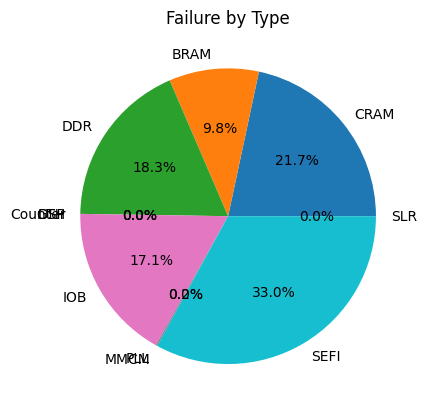

In [60]:
labels = 'CRAM', 'BRAM','DDR', 'Counter','DSP','GTH','IOB','PLL','MMCM','SEFI','SLR'
sizes = [CRAM_design_day, BRAM_design_day, DDR_device_day, CNT_design_day,DSP_design_day,\
         GTH_design_day,IOB_design_day,PLL_design_day,MMCM_design_day,SEFI_design_day,SLR_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

## What About MRAM external memory?

There are other options besides SDRAM DDR that perform much better in space enviroments.



<figure>
    <img src="https://b1967244.smushcdn.com/1967244/wp-content/uploads/consolidation-with-8Gb-v2.png"
    width="750"
    alt="MRAM Memory">
    <figcaption>MRAM memory option</figcaption>
</figure>

# Reaching Full Fault Tolerance

* CRAM -> TMR placement to reduce sensitivity to 0.01%
* BRAM -> EDAC with scrubbing to greatly reduce sensitvity
* DDR/IO -> Protocols to protect Data, Addr, Cmd
    *  3Dplus Radiation Intelligent Memory Controller (RMIC)
        * Reed Solomon
        * Addr/Cmd Parity
* External Devices -> Select MRAM or FDSOI memories
    * Avalanche MRAM
    * 3Dplus MNEMOSYNE

In [61]:
Other_design_day = 1E-4
Full_design_day =  SEFI_design_day+Other_design_day
print("FPGA will see a design failure every {0} years".format(1/Full_design_day/365.25))
TMR_GEO_MTTF = 1/Full_design_day

FPGA will see a design failure every 4.977910522058366 years


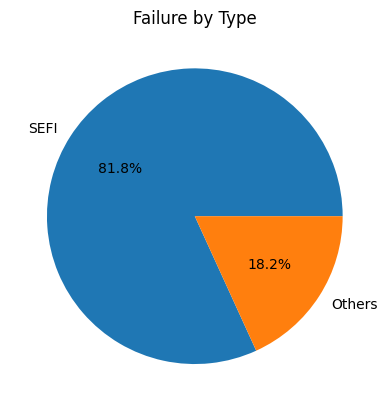

In [62]:
labels = 'SEFI','Others'
sizes = [SEFI_design_day,Other_design_day]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Failure by Type")
plt.show()

For the xqrKU060, the SEFI quickly becomes the limiting factor for fault tolerance.  

If you can allow for "down time", MTTF from 7 days to 5 years may be enough.

If you need critical function over a window that can't abort, a MTTF of 5 years may not be enough.

If you need better MTTF, then other technologies need to be considered.


For Heavy Ion Data,
* AMD Versal AI Edge 2302 will likely get up to __100__ years with the same design.
* Microchip RTG4 will likely get up to __1000__ years with the same design.

Summary:
*   Understand Orbit data and SEE rates
*   Perform Fault Injection
*   Trace Fault dependences and consequnces
*   Identify Critical Single-point failures
*   Provide targeted mitigation to help

# BRAM TMR Sensitivity Appendix

## Model

Some quick math to get a "close" value, check later with simulation

In [ ]:
from sympy import symbols, binomial
# Calculating the probability that exactly 2 out of 3 bits fail for 3 32Kb BRAMs
p_value = 1/(3*32*1024) #
P_X_equals_2_value = binomial(3, 2) * (p_value**2) * ((1-p_value)**(3-2))

P_X_equals_2_value

3.10437700237445e-10

In [ ]:
P_X_equals_2_value * 32 * 1024 * 405

0.00411983113735914

## TMR BRAM Simulation

Our Model value is about 5% below the median of TMR BRAM failures.
It seems to be a good conserative value.

In [99]:
import numpy as np
k32 = 32*1024
k96 = 96*1024
p96 = 1/k96
pbgeo = 0.0000000078773

In [100]:
#reset array
nTMR = []
TMR = []

* Add progress bar without soooo much output...

In [114]:
from ipywidgets import IntProgress
from IPython.display import display

IntProgress(value=0)

In [120]:
verbose_output = 0

In [121]:
f = IntProgress(min=0, max=100) # instantiate the bar
display(f) # display the bar

for sims in range(0,100):
  f.value += 1
  if (verbose_output):
      print("### ",sims," ###")
  TMR_a = np.zeros(k32, dtype=bool)
  TMR_b = np.zeros(k32, dtype=bool)
  TMR_c = np.zeros(k32, dtype=bool)
  pbgeoALL = pbgeo * 405 #simulate whole device and quicker testing
  time = 0
  flag_a = 0
  flag_b = 0
  flag_c = 0
  goto = 0
  while goto == 0:
    SEU_a = np.random.binomial(1,pbgeoALL,k32)
    SEU_b = np.random.binomial(1,pbgeoALL,k32)
    SEU_c = np.random.binomial(1,pbgeoALL,k32)
    TMR_a = TMR_a | SEU_a
    TMR_b = TMR_b | SEU_b
    TMR_c = TMR_c | SEU_c

    time += 1

    if (time%100 == 0):
      acount = 0
      bcount = 0
      ccount = 0
      for av, bv ,cv in zip(TMR_a , TMR_b, TMR_c):
        if av == 1:
          acount += 1
        if bv == 1:
          bcount += 1
        if cv == 1:
          ccount += 1
      if (verbose_output):
          print(time," counts ",acount,bcount,ccount)

    if ((TMR_a == 1 ).any() == True) and flag_a == 0:
        if (verbose_output):
          print ("A ",time)
        nTMR.append(time)
        flag_a = 1
    if ((TMR_b == 1 ).any() == True) and flag_b == 0:
        if (verbose_output):
          print ("B ",time)
        nTMR.append(time)
        flag_b = 1
    if ((TMR_c == 1 ).any() == True) and flag_c == 0:
        if (verbose_output):
          print ("C ",time)
        nTMR.append(time)
        flag_c = 1
    for av, bv ,cv in zip(TMR_a , TMR_b, TMR_c):
      if (av == 1) and (bv ==1):
        if (verbose_output):
          print ("A&B ",time)
        TMR.append(time)
        goto = 1
      if (av == 1) and (cv ==1):
        if (verbose_output):
          print ("A&C ",time)
        TMR.append(time)
        goto = 1
      if (cv == 1) and (bv ==1):
        if (verbose_output):
          print ("C&B ",time)
        TMR.append(time)
        goto = 1
  if (verbose_output):
      print("=== Results ===")
  nTMRCount = (len(nTMR))
  TMRCount = (len(TMR))
  nTMRFailRate = (sum(nTMR) / len(nTMR))
  TMRFailRate = (sum(TMR) / len(TMR))
  Sensitivity = nTMRFailRate/TMRFailRate
  model = 0.00411983113735914
  SensitivityDiff = (Sensitivity - model)/model
  if (verbose_output):
      print(nTMRCount,TMRCount,nTMRFailRate,TMRFailRate,Sensitivity,SensitivityDiff)
  is_above = 0
  limit = 1/(model*0.31361989)
  for tmrv in TMR:
    if tmrv >= limit:
      is_above += 1
  is_above_percent = is_above/TMRCount
  if (verbose_output):
        print(is_above_percent)


IntProgress(value=0)

In [122]:
print("=== Results ===")
print(nTMRCount,TMRCount,nTMRFailRate,TMRFailRate,Sensitivity,SensitivityDiff)
print(is_above_percent)
print(nTMR)
print(TMR)

=== Results ===
327 105 11.051987767584098 831.9238095238095 0.013284855705608691 2.224611704382729
0.5428571428571428
[1, 2, 4, 6, 14, 16, 5, 10, 14, 2, 4, 8, 1, 4, 9, 7, 9, 9, 1, 11, 22, 1, 7, 15, 8, 8, 34, 6, 10, 28, 1, 4, 13, 7, 11, 29, 13, 26, 35, 2, 7, 18, 15, 20, 24, 1, 8, 32, 4, 6, 30, 4, 15, 22, 3, 9, 15, 4, 6, 7, 1, 18, 18, 3, 4, 10, 4, 6, 7, 1, 1, 25, 1, 9, 34, 7, 10, 43, 4, 6, 16, 2, 9, 20, 7, 9, 27, 2, 6, 14, 3, 3, 25, 5, 14, 25, 2, 3, 8, 1, 8, 11, 1, 20, 32, 1, 3, 12, 1, 3, 8, 6, 17, 36, 6, 16, 33, 2, 13, 24, 6, 7, 16, 2, 9, 26, 7, 8, 12, 7, 8, 25, 3, 12, 16, 5, 5, 5, 3, 7, 12, 2, 14, 30, 4, 8, 13, 15, 20, 26, 7, 13, 15, 2, 24, 38, 1, 1, 11, 2, 13, 18, 17, 17, 20, 3, 3, 10, 2, 38, 46, 2, 3, 26, 4, 10, 22, 1, 5, 22, 1, 3, 9, 11, 13, 21, 4, 9, 17, 5, 9, 15, 5, 12, 21, 1, 3, 53, 6, 8, 14, 4, 16, 19, 7, 16, 16, 2, 5, 60, 4, 7, 12, 2, 5, 7, 4, 4, 8, 1, 8, 35, 2, 4, 13, 2, 9, 27, 3, 13, 25, 7, 9, 9, 4, 5, 17, 1, 5, 46, 2, 6, 12, 1, 7, 8, 2, 17, 23, 1, 2, 18, 3, 7, 16, 3, 7, 10,